# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

An HR company want to provide a professional advice on salary for its customers. It turns out to be very a valuable information for both the candidates, that are not sure how much money they should aim for in negotiation process and for companies that don't want to offer too low salary for an open position, which could discaurage talented candidates, but on the other hand they don't want to overpay them, as unnecessarily high salaries mean smaller budget for other companies expenses.

The company is currently using a simple model, which is average salary per industry and job type, but is looking for a more accurate solution, as suggesting too low or too high salary for a job position is leading to either not satisfied employees leaving their employer or not satisfied companies, that eventually finds out that they are paying too much. Result of both cases is negative review of the HR company, which logically leads to less customers.

The final product is expected to be a machine learning model delivered in a form, in which it can both easily used to predict new salaries but also can be easily maintained and retrained as the labour market changes and new data becomes available.

In [222]:
#import libraries
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

# author info
__author__ = "Ivana Hybenova"
__email__ = "ivana.hybenova1@gmail.com"

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [223]:
#loading the data into a Pandas dataframe
train_features = pd.read_csv('train_features.csv')
display(train_features.head())
print(train_features.shape)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


(1000000, 8)


In [224]:
train_salaries = pd.read_csv('train_salaries.csv')
display(train_salaries.head())
print(train_salaries.shape)

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


(1000000, 2)


In [225]:
data = pd.merge(train_features, train_salaries, left_on = 'jobId', right_on = 'jobId')
display(data.head())
print(data.shape)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


(1000000, 9)


### ---- 3 Clean the data ----

Goal of this section is to identify possible issues with current and future data used for model training.
It is important to make sure, that all invalid data are captured and handled in the final pipeline.

#### 3a. Looking for  invalid data 

In [226]:
# making sure each column has expected datatype
data.dtypes

jobId                  object
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
salary                  int64
dtype: object

In [227]:
# Duplicated rows
print('Number of duplicate rows = %d' % (data.duplicated().sum()))

Number of duplicate rows = 0


In [228]:
# Negative yearsExperience
negative_yearsExperience = data[data['yearsExperience'] < 0].copy()
# negative_yearsExperience
print("JobIds with negative amount of years of experience: ") 
display(negative_yearsExperience)


JobIds with negative amount of years of experience: 


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary


In [229]:
# Negative milesFromMetropolis
negative_milesFromMetropolis = data[data['milesFromMetropolis'] < 0].copy()
# negative_yearsExperience
print("JobIds with negative amount of miles from metropolis: ") 
display(negative_milesFromMetropolis)

JobIds with negative amount of miles from metropolis: 


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary


In [230]:
# Negative or 0 salary
invalid_salary = data[data['salary'] <= 0].copy()
# negative_yearsExperience
print("JobIds with negative or zero value for Salary: ") 
display(invalid_salary)
# dropping rows with 0 salary
data = data[~data['jobId'].isin(list(invalid_salary['jobId']))]

JobIds with negative or zero value for Salary: 


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


3b. Looking for missing data

In [231]:
for col in data.columns:
    print('\t%s: %d' % (col,data[col].isna().sum()))

	jobId: 0
	companyId: 0
	jobType: 0
	degree: 0
	major: 0
	industry: 0
	yearsExperience: 0
	milesFromMetropolis: 0
	salary: 0


##### Notes for automated preprocessing:
1. Make sure that all used numerical features don't have negative values
2. Make sure that each new datapoint for retraining the model has positive salary value

### ---- 4 Explore the data (EDA) ----

In [232]:
# dropping 'jobId' column from the data
data.drop('jobId', axis = 1, inplace = True)
data.head()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [233]:
data.describe()

,yearsExperience,milesFromMetropolis,salary
count,999995.000000,999995.000000,999995.000000
mean,11.992407,49.529381,116.062398
std,7.212390,28.877721,38.717163
min,0.000000,0.000000,17.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


##### 4.a) Exploration of target variable

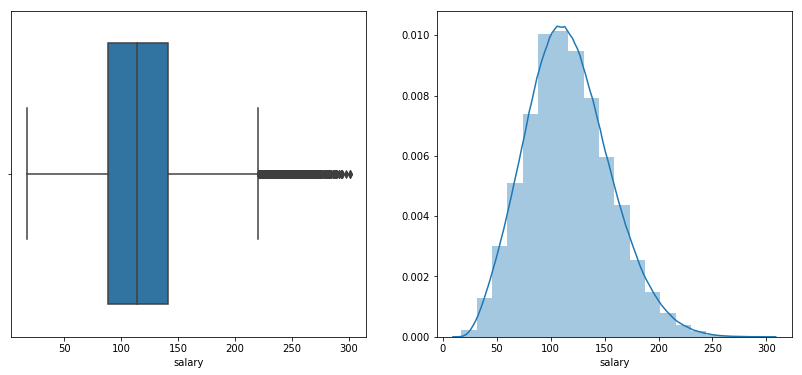

In [234]:
plt.figure(figsize = (14, 6))
plt.subplot(1,2,1)
sns.boxplot(data.salary)
plt.subplot(1,2,2)
sns.distplot(data.salary, bins=20)
plt.show()

Examination of outliers

In [235]:
# Computation of IQR
stat = data.salary.describe()
IQR = stat['75%'] - stat['25%']
upper = stat['75%'] + 1.5 * IQR
lower = stat['25%'] - 1.5 * IQR
print('The upper and lower bounds for suspected outliers are {} and {}.'.format(upper, lower))

The upper and lower bounds for suspected outliers are 220.5 and 8.5.


In [236]:
#check potential outlier above upper bound
data.loc[data.salary > 222.5, 'jobType'].value_counts()

CEO               2893
CFO               1308
CTO               1298
VICE_PRESIDENT     520
MANAGER            188
SENIOR              50
JUNIOR              16
Name: jobType, dtype: int64

In [237]:
# Check most suspicious potential outliers above upper bound
data[(data.salary > 222.5) & (data.jobType == 'JUNIOR')]

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1222,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
27710,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246
31355,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0,225
100042,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248
160333,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3,223
303778,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2,226
348354,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25,226
500739,COMP40,JUNIOR,DOCTORAL,ENGINEERING,OIL,21,0,227
627534,COMP5,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,29,230
645555,COMP36,JUNIOR,DOCTORAL,BUSINESS,FINANCE,24,1,225


##### 4.b) Exploration of numerical variables and relationship with the target

In [238]:
### Numerical variables
numeric_vars = [var for var in data.columns if data[var].dtypes!='O']
numeric_vars.remove('salary')
print('Numerical variables: ', numeric_vars)


Numerical variables:  ['yearsExperience', 'milesFromMetropolis']


In [239]:
def plot_feature(df, col):
    '''
    Make plot for each features
    left, the distribution of samples on the feature
    right, the dependance of salary on the feature
    '''
    plt.figure(figsize = (14, 6))
    plt.subplot(1, 2, 1)
    if df[col].dtype == 'int64':
        df[col].value_counts().sort_index().plot()
    else:
        #change the categorical variable to category type and order their level by the mean salary
        #in each category
        mean = df.groupby(col)['salary'].mean()
        df[col] = df[col].astype('category')
        levels = mean.sort_values().index.tolist()
        df[col].cat.reorder_categories(levels, inplace=True)
        df[col].value_counts().plot()
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel('Counts')
    plt.subplot(1, 2, 2)

    if df[col].dtype == 'int64' or col == 'companyId':
        #plot the mean salary for each category and fill between the (mean - std, mean + std)
        mean = df.groupby(col)['salary'].mean()
        std = df.groupby(col)['salary'].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, \
                         alpha = 0.1)
    else:
        sns.boxplot(x = col, y = 'salary', data=df)
    
    plt.xticks(rotation=45)
    plt.ylabel('Salaries')
    plt.show()

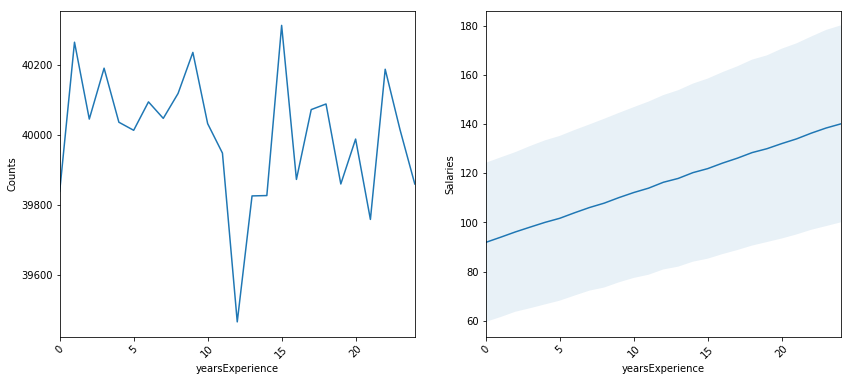

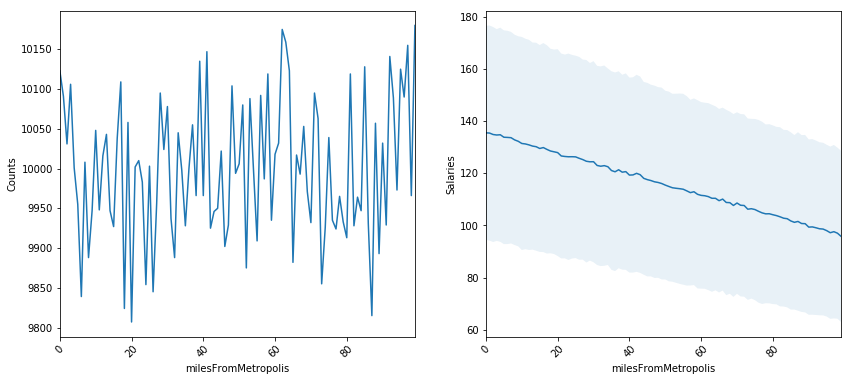

In [240]:
for var in numeric_vars:
    plot_feature(data, var)

##### 4.c) Exploration of categorical variables and relationship with the target

In [241]:
### Categorical variables
cat_vars = [var for var in data.columns if data[var].dtypes=='O']
# excluding
print('Number of categorical variables: ', len(cat_vars))

# checking cardinality
for var in cat_vars:
    print(var, data[var].nunique(), ' categories')
    if data[var].nunique() <= 10:
        print(data[var].unique())

# looking for rare labels
def analyse_rare_labels(df, var, rare_perc):
    df = df.copy()
    tmp = df.groupby(var)['salary'].count() / len(df)
    return tmp[tmp<rare_perc]

for variable in cat_vars:
    print(analyse_rare_labels(data, variable, 0.01))

Number of categorical variables:  5
companyId 63  categories
jobType 8  categories
['CFO' 'CEO' 'VICE_PRESIDENT' 'MANAGER' 'JUNIOR' 'JANITOR' 'CTO' 'SENIOR']
degree 5  categories
['MASTERS' 'HIGH_SCHOOL' 'DOCTORAL' 'BACHELORS' 'NONE']
major 9  categories
['MATH' 'NONE' 'PHYSICS' 'CHEMISTRY' 'COMPSCI' 'BIOLOGY' 'LITERATURE'
 'BUSINESS' 'ENGINEERING']
industry 7  categories
['HEALTH' 'WEB' 'AUTO' 'FINANCE' 'EDUCATION' 'OIL' 'SERVICE']
Series([], Name: salary, dtype: float64)
Series([], Name: salary, dtype: float64)
Series([], Name: salary, dtype: float64)
Series([], Name: salary, dtype: float64)
Series([], Name: salary, dtype: float64)


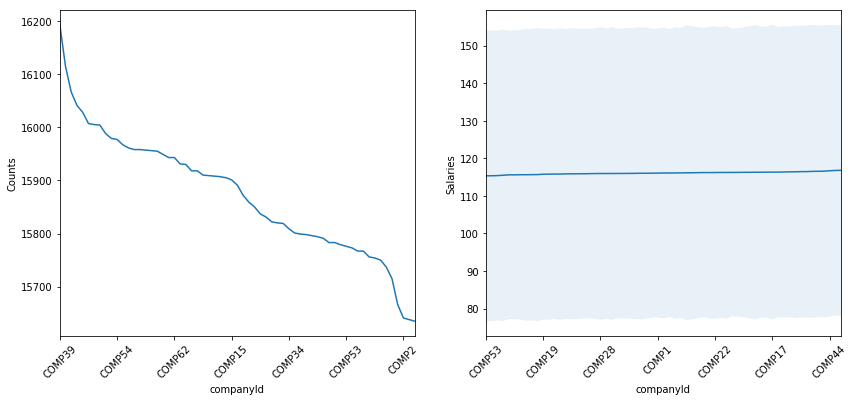

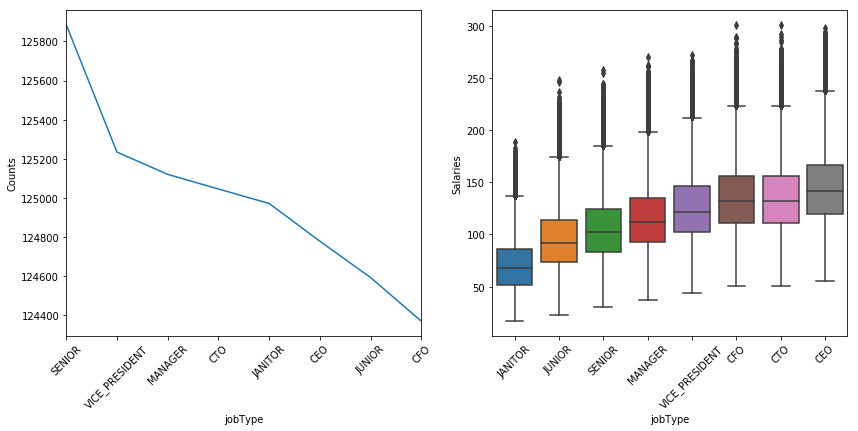

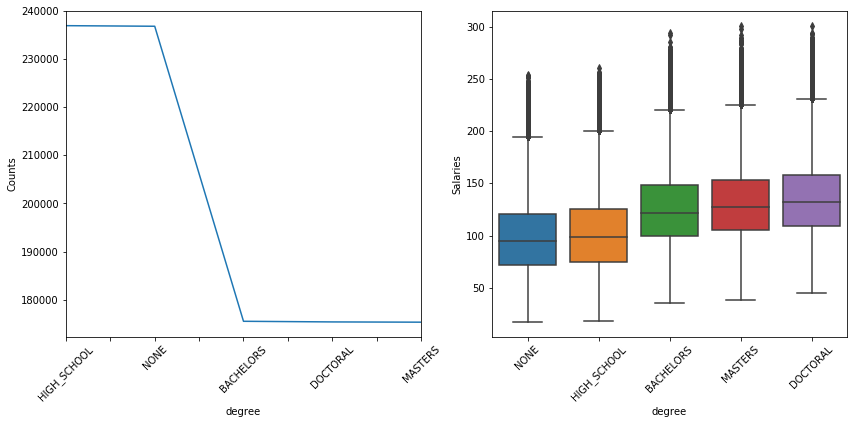

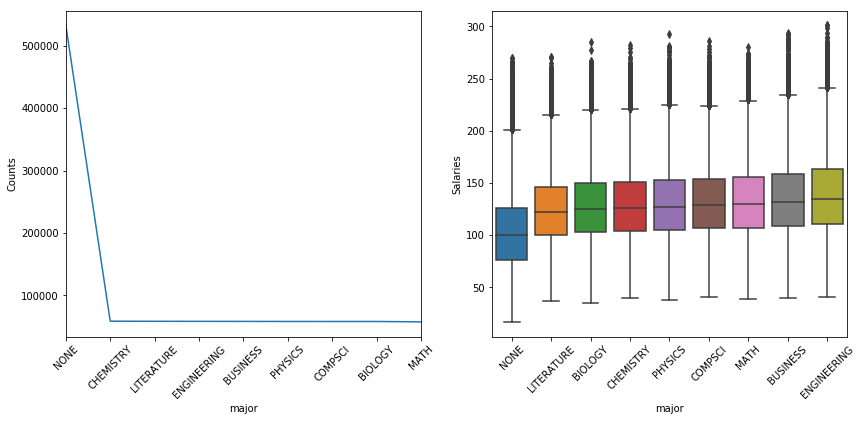

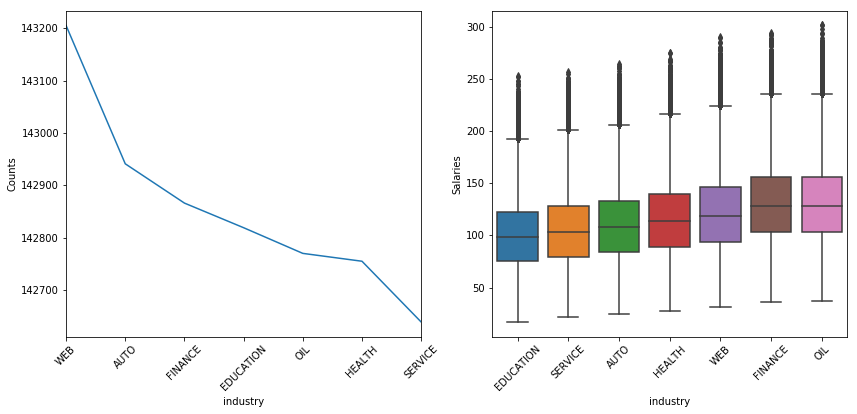

In [242]:
for var in cat_vars:
    plot_feature(data, var)

##### 4.d) Exploring relations between variables

In order to construct the heatmap in case of categorical variables the mean salary for each category will be used

In [278]:
def encode_label(df, col):
    #encode the categories using average salary for each category to replace label
    cat_dict ={}
    cats = df[col].cat.categories.tolist()
    for cat in cats:
        cat_dict[cat] = df[df[col] == cat]['salary'].mean()   
    df[col] = df[col].map(cat_dict)


In [282]:
df = data.copy()
for col in df.columns:
    if df[col].dtype.name == "category":
        encode_label(df, col)
df.head()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,115.345049,135.458547,130.505647,133.322042,115.735540,10,83,130
1,115.756548,145.311425,101.921085,102.583864,121.645362,3,73,101
2,116.224249,125.368630,135.490979,130.372436,115.735540,10,38,137
3,116.199380,115.368518,135.490979,129.072085,109.435222,8,17,142
4,115.888501,125.368630,125.454663,130.372436,130.747659,8,16,163


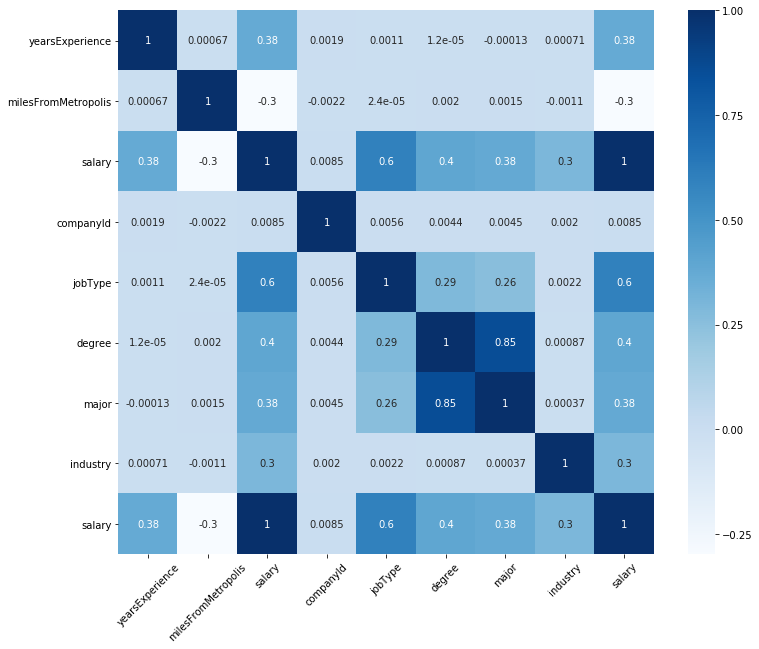

In [283]:
# Correlations between selected features and response
# jobId is discarded because it is unique for individual
fig = plt.figure(figsize=(12, 10))
sns.heatmap(df[num_vars + cat_vars + ['salary']].corr(), cmap='Blues', annot=True)
plt.xticks(rotation=45)
plt.show()

Notes for feature selection:
companyId is most likely not a significant predictor.

### ---- 5 Establish a baseline ----

In [5]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation

### ---- 6 Hypothesize solution ----

In [ ]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [ ]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

### ---- 8 Create models ----

In [15]:
#create and tune the models that you brainstormed during part 2

### ---- 9 Test models ----

In [1]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [ ]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [16]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data